In [12]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [ ]:
# --- Computational Approch ---
#define cost function coefficients(quadratic, linear, constant) for 2 generators
a1, b1, c1 = 10, 5, 0.01
a2, b2, c2 = 8, 6, 0.015
#define generator limits
P1_min, P1_max = 0, 100
P2_min, P2_max = 0, 100
#total load demand 
Pd = 80
#transmission power loss
Pl = 0

#define decision variables P1 and P2 for 2 generators
P1, P2 = sp.symbols('P1 P2', real=True, nonnegative=True)
C1 = a1 + b1*P1 + c1*P1**2
C2 = a2 + b2*P2 + c2*P2**2

#defines system of equations
#substitue p2 from power balance equation into cost functions so we have total cost as function of p1 only to solve
C_tot = C1 + C2.subs(P2, Pd - P1 + Pl)
dC_dP1 = sp.diff(C_tot, P1)
P1_opt = sp.solve(sp.Eq(dC_dP1, 0), P1)[0] 
P1_opt = max(P1_min, min(P1_max, P1_opt))
P2_opt = Pd - P1_opt
P2_opt = max(P2_min, min(P2_max, P2_opt))

C_min = C_tot.subs(P1, P1_opt)

print(f"P1* = {float(P1_opt):.2f} MW")
print(f"P2* = {float(P2_opt):.2f} MW")
print(f"Minimum Total Cost = ${float(C_min):.2f}")

P1* = 68.00 MW
P2* = 12.00 MW
Minimum Total Cost = $478.40


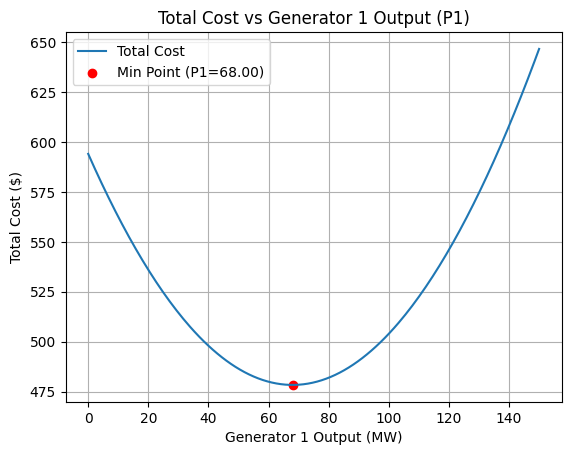

In [23]:
#--- Graphical Approach ---
#creates a function so that we can plot total cost vs P1
C_func = sp.lambdify(P1, C_tot, "numpy")

#define the domain for P1
P1_vals = np.linspace(0, 150, 200)
#find corresponding cost values by using created function
C_vals = C_func(P1_vals)
plt.plot(P1_vals, C_vals, label="Total Cost")
plt.scatter(float(P1_opt), float(C_min), color='red', label=f"Min Point (P1={float(P1_opt):.2f})")
plt.title("Total Cost vs Generator 1 Output (P1)")
plt.xlabel("Generator 1 Output (MW)")
plt.ylabel("Total Cost ($)")
plt.grid(True)
plt.legend()
plt.show()


Status: optimal
Optimal Total Cost = $478.40
P1 = 68.00 MW
P2 = 12.00 MW


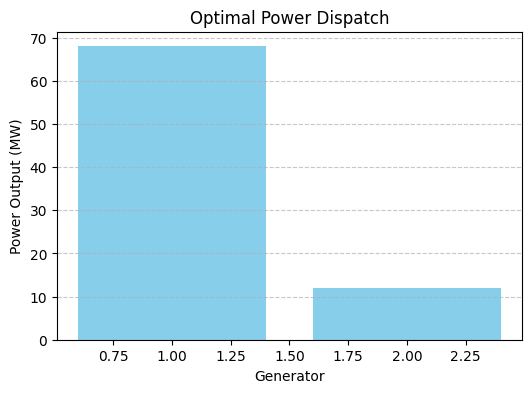

In [24]:
#---CVXPY Optimization for a Single Hour Classic EDP ---
# --- Parameters ---
#Generator quadratic, linear, and constant cost coefficents
a = np.array([10, 8])
b = np.array([5, 6])
c = np.array([0.01, 0.015])

#Generation limits min and max power output 
P_min = np.array([0, 0])
P_max = np.array([100, 100])

#Total load demand 
Pd = 80
 
#Transmission power loss 
Pl = 0


# --- Decision variable ---
m = len(a)
P = cp.Variable(m) #each element of power output is constrained to be non negative 


# --- Objective ---
#minimize total generation cost to meed load demand 
cost = cp.sum(a + cp.multiply(b, P) + cp.multiply(c, cp.square(P)))
objective = cp.Minimize(cost)


#--- Constraints ---
constraints = [
    cp.sum(P) == Pd + Pl,  #power balance 
    P >= P_min,            #minimum generation limits
    P <= P_max,           #maximum generation limits
    P >= 0
]

# --- Problem definition and solve ---
problem = cp.Problem(objective, constraints)
problem.solve()

# --- Results ---
print("Status:", problem.status)
print("Optimal Total Cost = $%.2f" % problem.value)
for i in range(m):
    print(f"P{i+1} = {P.value[i]:.2f} MW")

#--- Graphs ---
plt.figure(figsize=(6, 4))
plt.bar(range(1, m+1), P.value, color='skyblue')
plt.xlabel('Generator')
plt.ylabel('Power Output (MW)')
plt.title('Optimal Power Dispatch')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
#---CVXPY Optimization for a Multi Hour(24) Classic EDP ---
hours = 24
generators = 2

# --- Parameters ---
#Generator quadratic, linear, and constant cost coefficents
a = np.array([[10, 8]] * hours)
b = np.array([[5, 6]] * hours)
c = np.array([[0.01, 0.015]] * hours)

#Generation limits min and max power output
P_min = np.array([[0, 0]] * hours)
P_max = np.array([[100, 100]] * hours)

#Total load demand for 24 hours (example values) from 
